In [35]:
pip install torch-geometric -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
Note: you may need to restart the kernel to use updated packages.


In [36]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

import torch_geometric
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data


import torch.nn.functional as F
from torch_geometric.nn import MessagePassing

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder



# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
train_seq = pd.read_csv('/kaggle/input/stanford-rna-3d-folding/train_sequences.csv')
train_label = pd.read_csv('/kaggle/input/stanford-rna-3d-folding/train_labels.csv')
test_seq= pd.read_csv('/kaggle/input/stanford-rna-3d-folding/test_sequences.csv')
val_seq=pd.read_csv('/kaggle/input/stanford-rna-3d-folding/validation_sequences.csv')
val_label= pd.read_csv('/kaggle/input/stanford-rna-3d-folding/validation_labels.csv')

Dimentions of the datasets

In [38]:
print(train_seq.head())
print(train_label.head())
print("sequences shape", train_seq.shape)
print("labels shape", train_label.shape)

  target_id                            sequence temporal_cutoff  \
0    1SCL_A       GGGUGCUCAGUACGAGAGGAACCGCACCC      1995-01-26   
1    1RNK_A  GGCGCAGUGGGCUAGCGCCACUCAAAAGGCCCAU      1995-02-27   
2    1RHT_A            GGGACUGACGAUCACGCAGUCUAU      1995-06-03   
3    1HLX_A                GGGAUAACUUCGGUUGUCCC      1995-09-15   
4    1HMH_E  GGCGACCCUGAUGAGGCCGAAAGGCCGAAACCGU      1995-12-07   

                                         description  \
0               THE SARCIN-RICIN LOOP, A MODULAR RNA   
1  THE STRUCTURE OF AN RNA PSEUDOKNOT THAT CAUSES...   
2  24-MER RNA HAIRPIN COAT PROTEIN BINDING SITE F...   
3  P1 HELIX NUCLEIC ACIDS (DNA/RNA) RIBONUCLEIC ACID   
4  THREE-DIMENSIONAL STRUCTURE OF A HAMMERHEAD RI...   

                                       all_sequences  
0  >1SCL_1|Chain A|RNA SARCIN-RICIN LOOP|Rattus n...  
1  >1RNK_1|Chain A|RNA PSEUDOKNOT|null\nGGCGCAGUG...  
2  >1RHT_1|Chain A|RNA (5'-R(P*GP*GP*GP*AP*CP*UP*...  
3  >1HLX_1|Chain A|RNA (5'-R(*GP*GP*GP*A

In [ ]:
print(train_seq.isnull().sum())
print(train_label.isnull().sum())

In [39]:
# Keep only essential columns
train_seq = train_seq[["target_id", "sequence"]]  # Drop temporal_cutoff, description, all_sequences
train_label = train_label[["ID", "resname", "resid", "x_1", "y_1", "z_1"]]  # Keep coordinates

In [40]:
# Extract target_id from ID (e.g., convert "1SCL_A_1" → "1SCL_A")
train_label["target_id"] = train_label["ID"].str.rsplit("_", n=1).str[0]  

# Merge on target_id
data = pd.merge(train_seq, train_label, on="target_id")

data.head()

,target_id,sequence,ID,resname,resid,x_1,y_1,z_1
0,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,1SCL_A_1,G,1,13.760,-25.974001,0.102
1,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,1SCL_A_2,G,2,9.310,-29.638000,2.669
2,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,1SCL_A_3,G,3,5.529,-27.813000,5.878
3,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,1SCL_A_4,U,4,2.678,-24.900999,9.793
4,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,1SCL_A_5,G,5,1.827,-20.136000,11.793


In [41]:
data = data.drop(columns=["ID"])  # Remove redundant column


In [42]:
data.head()

,target_id,sequence,resname,resid,x_1,y_1,z_1
0,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,G,1,13.760,-25.974001,0.102
1,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,G,2,9.310,-29.638000,2.669
2,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,G,3,5.529,-27.813000,5.878
3,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,U,4,2.678,-24.900999,9.793
4,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,G,5,1.827,-20.136000,11.793


In [43]:
data['resname'] = data['resname'].astype(str)
data = pd.get_dummies(data, columns=['resname'], prefix='')

In [44]:
data.head()

,target_id,sequence,resid,x_1,y_1,z_1,_-,_A,_C,_G,_U,_X
0,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,1,13.760,-25.974001,0.102,False,False,False,True,False,False
1,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,2,9.310,-29.638000,2.669,False,False,False,True,False,False
2,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,3,5.529,-27.813000,5.878,False,False,False,True,False,False
3,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,4,2.678,-24.900999,9.793,False,False,False,False,True,False
4,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,5,1.827,-20.136000,11.793,False,False,False,True,False,False


In [45]:
one_hot_cols = ['_-', '_A', '_C', '_G', '_U', '_X']
data[one_hot_cols] = data[one_hot_cols].astype(int)  # True→1, False→0
data = data.drop(columns=['_-', '_X'])  # Remove non-standard bases

In [46]:
data.head()

,target_id,sequence,resid,x_1,y_1,z_1,_A,_C,_G,_U
0,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,1,13.760,-25.974001,0.102,0,0,1,0
1,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,2,9.310,-29.638000,2.669,0,0,1,0
2,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,3,5.529,-27.813000,5.878,0,0,1,0
3,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,4,2.678,-24.900999,9.793,0,0,0,1
4,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,5,1.827,-20.136000,11.793,0,0,1,0


In [47]:
data[['x_1', 'y_1', 'z_1']] = (data[['x_1', 'y_1', 'z_1']] - data[['x_1', 'y_1', 'z_1']].mean()) / data[['x_1', 'y_1', 'z_1']].std()

In [ ]:
data.head()

In [48]:
# Count residues per unique sequence
residues_per_sequence = data.groupby('sequence')['resid'].max()
print(residues_per_sequence.describe())  # Stats (mean, max, etc.)
print("\nLongest sequence:", residues_per_sequence.max(), "residues")


count     784.000000
mean      168.237245
std       533.609057
min         3.000000
25%        22.000000
50%        37.000000
75%        80.250000
max      4298.000000
Name: resid, dtype: float64

Longest sequence: 4298 residues


In [49]:
max_residues = 500  # Adjust based on your GPU memory
data = data[data.groupby('sequence')['resid'].transform('max') <= max_residues]

In [50]:
data.shape

(48360, 10)

In [51]:
data.isnull().sum()

target_id       0
sequence        0
resid           0
x_1          4865
y_1          4865
z_1          4865
_A              0
_C              0
_G              0
_U              0
dtype: int64

In [52]:
# Identify sequences with missing coordinates  
bad_sequences = data[data[['x_1', 'y_1', 'z_1']].isnull().any(axis=1)]['sequence'].unique()  
 
# Remove all residues from these sequences  
clean_data = data[~data['sequence'].isin(bad_sequences)]  

In [53]:
# Normalize resid per sequence
clean_data = clean_data.copy() 
clean_data['max_resid'] = clean_data.groupby('sequence')['resid'].transform('max')
clean_data['resid_norm'] = clean_data['resid'] / clean_data['max_resid']
clean_data = clean_data.drop(columns=['max_resid'])

In [54]:
print("Remaining sequences:", clean_data['sequence'].nunique())  
print("Missing values left:", clean_data[['x_1', 'y_1', 'z_1']].isnull().sum())  

Remaining sequences: 554
Missing values left: x_1    0
y_1    0
z_1    0
dtype: int64


In [55]:
clean_data.head()

,target_id,sequence,resid,x_1,y_1,z_1,_A,_C,_G,_U,resid_norm
0,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,1,-0.452356,-0.957242,-0.824962,0,0,1,0,0.034483
1,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,2,-0.482541,-0.989122,-0.803464,0,0,1,0,0.068966
2,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,3,-0.508188,-0.973243,-0.776591,0,0,1,0,0.103448
3,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,4,-0.527527,-0.947905,-0.743805,0,0,0,1,0.137931
4,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,5,-0.533300,-0.906445,-0.727056,0,0,1,0,0.172414


In [56]:
residue_counts = clean_data.groupby('sequence')['resid'].nunique()  
sequence_lengths = clean_data.groupby('sequence')['resid'].max()  
if not (residue_counts == sequence_lengths).all():  
    print("Warning: Missing or duplicate residues in some sequences!")
if clean_data[['x_1', 'y_1', 'z_1']].isnull().any().any():  
    print("Warning: NaN values still exist in coordinates!")  
if not (clean_data[['_A', '_U', '_G', '_C']].sum(axis=1) == 1).all():  
    print("Warning: Some residues have invalid one-hot encoding!")  
if (sequence_lengths == 0).any():  
    print("Warning: Empty sequences detected!") 

In [57]:
clean_data.head()

,target_id,sequence,resid,x_1,y_1,z_1,_A,_C,_G,_U,resid_norm
0,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,1,-0.452356,-0.957242,-0.824962,0,0,1,0,0.034483
1,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,2,-0.482541,-0.989122,-0.803464,0,0,1,0,0.068966
2,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,3,-0.508188,-0.973243,-0.776591,0,0,1,0,0.103448
3,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,4,-0.527527,-0.947905,-0.743805,0,0,0,1,0.137931
4,1SCL_A,GGGUGCUCAGUACGAGAGGAACCGCACCC,5,-0.533300,-0.906445,-0.727056,0,0,1,0,0.172414


In [58]:
import torch
import numpy as np
from torch_geometric.data import Data
from scipy.spatial.distance import pdist, squareform

def build_rna_graphs(clean_data, spatial_cutoff=8.0):
    dataset = []
    for seq in clean_data["sequence"].unique():
        seq_mask = clean_data["sequence"] == seq
        seq_df = clean_data.loc[seq_mask].sort_values('resid').reset_index(drop=True)
        n = seq_df.shape[0]
        if n < 2:
            continue

        # Node features: [_A, _U, _G, _C, resid_normalized]
        if 'resid_norm' not in seq_df.columns:
            seq_df['resid_norm'] = (seq_df['resid'] - seq_df['resid'].min()) / (seq_df['resid'].max() - seq_df['resid'].min() + 1e-8)
        node_features = torch.tensor(seq_df[['_A', '_U', '_G', '_C', 'resid_norm']].values, dtype=torch.float)
        y = torch.tensor(seq_df[['x_1', 'y_1', 'z_1']].values, dtype=torch.float)

        # Sequential edges (i <-> i+1, undirected)
        sources = np.arange(n - 1)
        targets = np.arange(1, n)
        seq_edges = np.stack([sources, targets], axis=0)
        seq_edges_rev = np.stack([targets, sources], axis=0)
        all_edges = [seq_edges, seq_edges_rev]

        # Spatial edges (<spatial_cutoff Å, undirected, no self-loops, no backbone edges)
        coords = seq_df[['x_1', 'y_1', 'z_1']].values
        dist_matrix = squareform(pdist(coords))
        s, t = np.where((dist_matrix < spatial_cutoff) & (dist_matrix > 0))
        # Remove backbone edges from spatial set
        backbone_pairs = set(tuple(sorted((i, i+1))) for i in range(n-1))
        spatial_pairs = set(tuple(sorted((a, b))) for a, b in zip(s, t))
        spatial_pairs = spatial_pairs - backbone_pairs
        if spatial_pairs:
            spatial_edges = np.array(list(spatial_pairs)).T
            spatial_edges_rev = np.flip(spatial_edges, axis=0)
            all_edges += [spatial_edges, spatial_edges_rev]

        # Combine and remove duplicate edges
        edge_index = np.hstack(all_edges)
        # Each edge as sorted tuple
        edge_tuples = [tuple(sorted(e)) for e in edge_index.T]
        unique_tuples = list(dict.fromkeys(edge_tuples))
        edge_index = torch.tensor(np.array(unique_tuples).T, dtype=torch.long)

        # Build Data object
        data = Data(x=node_features, edge_index=edge_index, y=y)
        dataset.append(data)
    return dataset

In [59]:
dataset = build_rna_graphs(clean_data, spatial_cutoff=8.0)

In [101]:
# === Normalize coordinates ===

# 1. Stack all coordinates across all graphs
all_coords = torch.cat([data.y.cpu() for data in dataset], dim=0)
mean = all_coords.mean(dim=0)
std = all_coords.std(dim=0)

for data in dataset:
    data.y = (data.y.cpu() - mean) / std

# (Optional) If you use initial coordinates as input features elsewhere, normalize them too.
# for data in dataset:
#     data.initial_coords = (data.initial_coords - mean) / std

# 3. Save mean and std for denormalizing predictions later
torch.save({'mean': mean, 'std': std}, 'coords_mean_std.pt')

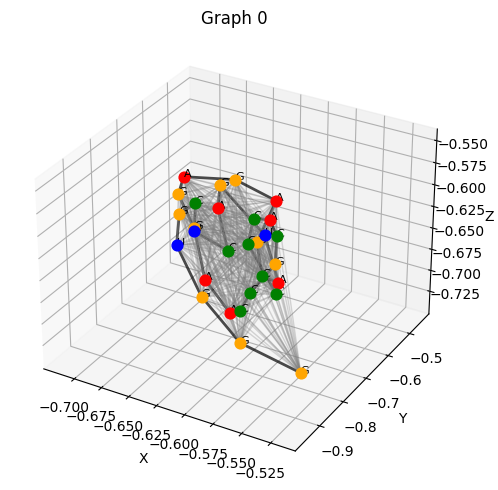

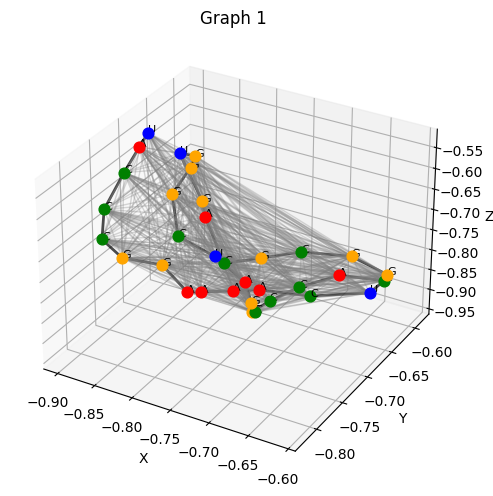

In [102]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

def visualize_graph(data, title, show_spatial=True):
    pos = data.y.cpu().numpy()
    node_types = data.x[:, :4].argmax(dim=1).cpu().numpy()
    colors = ['red', 'blue', 'orange', 'green']
    labels = ['A', 'U', 'G', 'C']
    n = len(pos)

    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d')
    for i, (x, y, z) in enumerate(pos):
        ax.scatter(x, y, z, color=colors[node_types[i]], s=60)
        ax.text(x, y, z, labels[node_types[i]], size=8)
    # Plot backbone (i<->i+1)
    for i in range(n-1):
        ax.plot(*zip(pos[i], pos[i+1]), color='black', alpha=0.7, linewidth=2)
    # Plot spatial edges, faint gray
    if show_spatial:
        edge_index = data.edge_index.cpu().numpy()
        backbone_pairs = set([(i, i+1) for i in range(n-1)] + [(i+1, i) for i in range(n-1)])
        for src, tgt in edge_index.T:
            if (src, tgt) not in backbone_pairs:
                ax.plot(*zip(pos[src], pos[tgt]), color='gray', alpha=0.3, linewidth=1)
    ax.set_title(title)
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    plt.tight_layout()
    return fig

# Visualize the first two graphs
fig1 = visualize_graph(dataset[0], "Graph 0")
fig2 = visualize_graph(dataset[1], "Graph 1")
plt.show()

In [103]:
for i, data in enumerate(dataset[:2]):
    print(f"Graph {i}:")
    print("  # Nodes:", data.num_nodes)
    print("  # Edges:", data.edge_index.shape[1])

Graph 0:
  # Nodes: 29
  # Edges: 406
Graph 1:
  # Nodes: 34
  # Edges: 561


In [104]:
for i, data in enumerate(dataset[:3]):
    print(f"Graph {i}:")
    print("  # Nodes:", data.num_nodes)
    print("  # Edges:", data.num_edges)
    print("  Node features shape:", data.x.shape)
    print("  Edge_index shape:", data.edge_index.shape)
    print("  Example node features:", data.x[:5])
    print("  Example y (coords):", data.y[:5])
    print()

Graph 0:
  # Nodes: 29
  # Edges: 406
  Node features shape: torch.Size([29, 5])
  Edge_index shape: torch.Size([2, 406])
  Example node features: tensor([[0.0000, 0.0000, 1.0000, 0.0000, 0.0345],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0690],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.1034],
        [0.0000, 1.0000, 0.0000, 0.0000, 0.1379],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.1724]], device='cuda:0')
  Example y (coords): tensor([[-0.5184, -0.9129, -0.6939],
        [-0.5624, -0.9501, -0.6680],
        [-0.5998, -0.9316, -0.6356],
        [-0.6280, -0.9021, -0.5962],
        [-0.6364, -0.8538, -0.5760]])

Graph 1:
  # Nodes: 34
  # Edges: 561
  Node features shape: torch.Size([34, 5])
  Edge_index shape: torch.Size([2, 561])
  Example node features: tensor([[0.0000, 0.0000, 1.0000, 0.0000, 0.0294],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0588],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0882],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.1176],
        [0.0000, 0.0000, 0.00

In [105]:
edge_set = set(tuple(sorted(pair)) for pair in data.edge_index.cpu().numpy().T)
print(f"# Unique undirected edges: {len(edge_set)}")

# Unique undirected edges: 276


In [106]:
print(len(dataset))  # Should equal the number of unique sequences

554


In [107]:
loader = DataLoader(dataset, batch_size=1, shuffle=False)

In [65]:
!pip install egnn-pytorch

In [108]:


class EGNNLayer(nn.Module):
    def __init__(self, node_dim, edge_dim=0, hidden_dim=64):
        super().__init__()
        self.edge_mlp = nn.Sequential(
            nn.Linear(2 * node_dim + 1 + edge_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.node_mlp = nn.Sequential(
            nn.Linear(node_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, node_dim)
        )
        self.coord_mlp = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Tanh()
        )

    def forward(self, x, coords, edge_index):
        row, col = edge_index  # shape [E], [E]
        coord_diff = coords[row] - coords[col]               # [E, 3]
        dist = torch.norm(coord_diff, dim=1, keepdim=True)   # [E, 1]
        edge_feat = torch.cat([x[row], x[col], dist], dim=1) # [E, 2*node_dim+1]

        m = self.edge_mlp(edge_feat)  # [E, hidden_dim]

        # Aggregate messages
        agg = torch.zeros(x.size(0), m.size(1), device=x.device)  # [N, hidden_dim]
        agg = agg.index_add_(0, row, m)

        node_input = torch.cat([x, agg], dim=1)
        x = x + self.node_mlp(node_input)

        # Coordinate update
        
        delta = self.coord_mlp(m) * coord_diff  # [E, 3]
        coord_update = torch.zeros_like(coords)  # [N, 3]
        coord_update = coord_update.index_add_(0, row, delta)
        coords = coords + coord_update

        return x, coords

class EGNNRegression(nn.Module):
    def __init__(self, node_dim=5, hidden_dim=64, n_layers=4):
        super().__init__()
        self.layers = nn.ModuleList([
            EGNNLayer(node_dim, hidden_dim=hidden_dim)
            for _ in range(n_layers)
        ])
        self.final = nn.Linear(node_dim, 3)  # predict final position offset

    def forward(self, data):
        x = data.x                     # [N, node_dim]
        coords = data.y                # [N, 3] — ground-truth init pos
        edge_index = data.edge_index   # [2, E]

        for layer in self.layers:
            x, coords = layer(x, coords, edge_index)

        return self.final(x) + coords  # refine coords

In [134]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EGNNRegression(node_dim=5).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

model.train()
for epoch in range(50):  # adjust as needed
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        pred = model(data)
        loss = loss_fn(pred, data.y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch} Loss: {total_loss:.4f}")

Epoch 0 Loss: 240856702757795.7188
Epoch 1 Loss: 4928490113695.1201
Epoch 2 Loss: 225305274914.7739
Epoch 3 Loss: 138596397753.8426
Epoch 4 Loss: 114376307363.9282
Epoch 5 Loss: 1443799170.8078
Epoch 6 Loss: 3502938909.1221
Epoch 7 Loss: 3315392455.3205
Epoch 8 Loss: 23767097810.4521
Epoch 9 Loss: 437173066.6954
Epoch 10 Loss: 23053996.4321
Epoch 11 Loss: 5098917309.9064
Epoch 12 Loss: 9017323.1633
Epoch 13 Loss: 141311.9559
Epoch 14 Loss: 20258411.1995
Epoch 15 Loss: 33074286.3190
Epoch 16 Loss: 2318283855.6625
Epoch 17 Loss: 59075.1488
Epoch 18 Loss: 8242573.0696
Epoch 19 Loss: 9230152.4535
Epoch 20 Loss: 5441095.0449
Epoch 21 Loss: 757085919.5825
Epoch 22 Loss: 3911674.7253
Epoch 23 Loss: 646798.2905
Epoch 24 Loss: 1722586.5357
Epoch 25 Loss: 1303.1638
Epoch 26 Loss: 11136.2763
Epoch 27 Loss: 5230020.9836
Epoch 28 Loss: 141330170.4416
Epoch 29 Loss: 1193.7374
Epoch 30 Loss: 14283.4653
Epoch 31 Loss: 32108.7906
Epoch 32 Loss: 47164.0022
Epoch 33 Loss: 22303.6120
Epoch 34 Loss: 322.23

In [135]:
print("y:", data.y.min(), data.y.max(), data.y.mean())
print("pred:", pred.min(), pred.max(), pred.mean())

y: tensor(0.9803, device='cuda:0') tensor(2.0095, device='cuda:0') tensor(1.5285, device='cuda:0')
pred: tensor(0.9983, device='cuda:0', grad_fn=<MinBackward1>) tensor(2.0049, device='cuda:0', grad_fn=<MaxBackward1>) tensor(1.5305, device='cuda:0', grad_fn=<MeanBackward0>)


In [136]:
import torch

stats = torch.load('coords_mean_std.pt')
mean = stats['mean'].cpu().numpy()  # shape: (3,)
std = stats['std'].cpu().numpy()

pred_coords_np = pred_coords.cpu().numpy()
pred_coords_denorm = pred_coords_np * std + mean

print(pred_coords_denorm)

[[-5.0643144e+00  2.8866392e-01 -2.0416520e+00]
 [-4.0902834e+00  1.0350112e+00 -2.1622651e+00]
 [-3.2512715e+00  7.7047354e-01 -2.1985338e+00]
 [-4.4003129e+00  5.8165345e+00 -5.6884828e+00]
 [-2.3392649e+00  4.5151979e-01 -2.1037471e+00]
 [-5.3421959e-02 -1.0561517e+00 -6.0049218e-01]
 [-2.9498987e+00 -6.4972907e-01 -2.9383559e+00]
 [ 5.3564601e-02 -9.9682623e-01 -5.3374594e-01]
 [-2.5287490e+00 -9.1083688e-01 -2.1952441e+00]
 [-1.4176309e+00 -2.6671106e-01 -8.9295119e-01]
 [-2.6204090e+00 -1.0282792e+00 -1.7423596e+00]
 [-1.8636390e+00 -8.0660027e-01 -1.8962247e+00]
 [ 2.2626765e-02 -1.0061314e+00 -4.4424850e-01]
 [-9.1152346e-01 -1.3559286e-01 -5.2742022e-01]
 [-1.4939829e+00 -7.4147344e-01 -1.4842110e+00]
 [-7.1956992e-01 -1.1715256e-01 -3.6816376e-01]
 [-1.2822442e+00 -7.8827214e-01 -1.3214524e+00]
 [-5.7730418e-01 -1.4956720e-01 -2.4218589e-01]
 [-4.6386480e-01 -1.6494222e-01 -1.3590917e-01]
 [-9.7546375e-01 -7.7290678e-01 -1.0558910e+00]
 [-9.1252565e-01 -7.9899949e-01 -1.02682

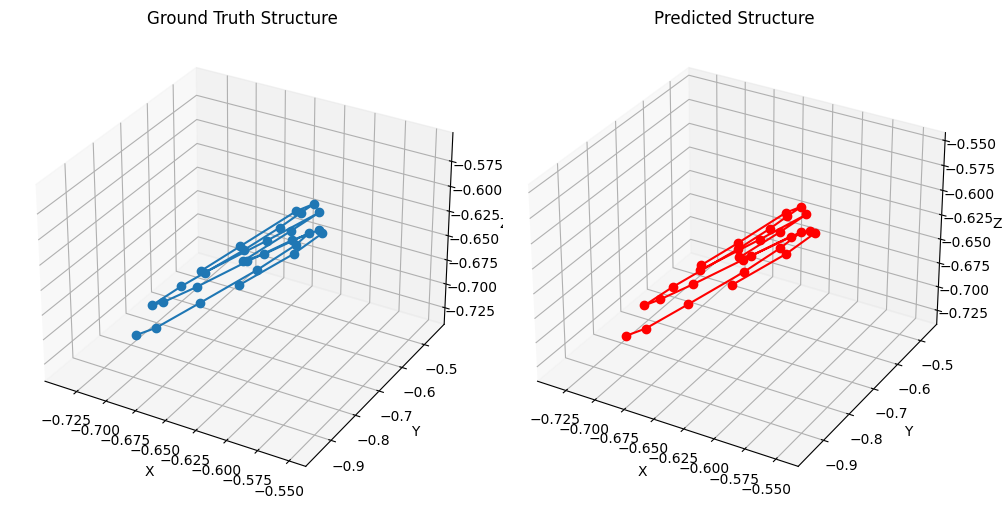

In [137]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

# Get one example (here, the first RNA graph)
data = dataset[0].to(device)
model.eval()
with torch.no_grad():
    pred = model(data).cpu().numpy()           # shape: [num_residues, 3]
    real = data.y.cpu().numpy()                # shape: [num_residues, 3]

# Optionally, unnormalize if you normalized target coordinates earlier

# Prepare for plotting
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# Plot real RNA
ax.plot(real[:, 2], real[:, 1], real[:, 2], '-o', label='Real')
ax.set_title("Ground Truth Structure")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Plot predicted RNA
ax2.plot(pred[:, 2], pred[:, 1], pred[:, 2], '-o', label='Predicted', color='r')
ax2.set_title("Predicted Structure")
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.tight_layout()
plt.show()

In [133]:
val_seq.head()
val_label.head()

,ID,resname,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,...,z_37,x_38,y_38,z_38,x_39,y_39,z_39,x_40,y_40,z_40
0,R1107_1,G,1,-5.499,8.520000,8.605000,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18
1,R1107_2,G,2,-5.826,10.453000,14.010000,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18
2,R1107_3,G,3,-5.849,14.768000,17.584999,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18
3,R1107_4,G,4,-5.784,19.985001,18.666000,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18
4,R1107_5,G,5,-5.755,25.533001,17.132999,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,...,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18,-1.000000e+18
